In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision import models
from matplotlib import pyplot as plt
from torchvision import transforms
from tqdm import tqdm
from torch.utils.data import Dataset, TensorDataset
BatchSize = 1
from thundernna import *
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [22]:
pretrained_model = models.resnet18(pretrained=True,  progress = True).to(device)
_=pretrained_model.eval()

In [23]:
transform = transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )

dataset = torchvision.datasets.ImageNet(root="./", split='val',
                             transform=transform)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)

def recreate_image(im_as_var):
    """
        Recreates images from a torch variable, sort of reverse preprocessing

    Args:
        im_as_var (torch variable): Image to recreate

    returns:
        recreated_im (numpy arr): Recreated image in array
    """
    reverse_mean = [-0.485, -0.456, -0.406]
    reverse_std = [1/0.229, 1/0.224, 1/0.225]
    recreated_im = torch.clone(im_as_var)
    recreated_im = recreated_im.cpu().numpy()[0]
    for c in range(3):
        recreated_im[c] /= reverse_std[c]
        recreated_im[c] -= reverse_mean[c]
    recreated_im[recreated_im > 1] = 1
    recreated_im[recreated_im < 0] = 0
    recreated_im = np.round(recreated_im * 255)

    recreated_im = np.uint8(recreated_im).transpose(1, 2, 0)
    # Convert RBG to GBR
    #recreated_im = recreated_im[..., ::-1]
    return recreated_im

In [101]:
epsilon = 0.01
correct = 0

target class: 740 -> predict class: 740


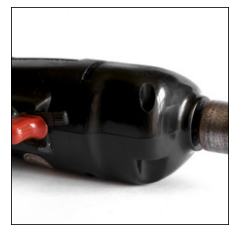

In [152]:
with torch.no_grad():
    while True:
        img, target = next(iter(test_loader))
        img, target = img.to(device), target.to(device)
        out = pretrained_model(img)
        final_pred = out.data.max(1, keepdim=True)[1]
        if (target.data.item() - final_pred.data.item() == 0):
            break
plt.imshow(recreate_image(img.cpu()))
plt.xticks([])
plt.yticks([])
print("target class:",target.data.item(),"-> predict class:",final_pred.data.item())

target class: 740 -> predict class: 587
Fail!


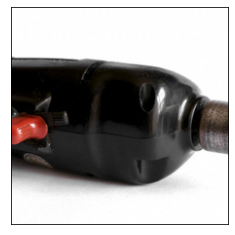

In [153]:
adversarial_img = thundernna_attack(img, target, pretrained_model, epsilon)
plt.imshow(recreate_image(adversarial_img.detach().cpu()))
plt.xticks([])
plt.yticks([])
with torch.no_grad():
    out = pretrained_model(adversarial_img)
    final_pred = out.data.max(1, keepdim=True)[1]
print("target class:",target.data.item(),"-> predict class:",final_pred.data.item())
if (target.data.item() - final_pred.data.item() == 0):
    print("Correct!")
else:
    print("Fail!")